## Problem Definition

In [1]:
import scipy
import numpy as np
import gym
from gym import spaces
import torch
import random
from tqdm import tqdm

from typing import List, Union

RANDOM_SEED = 42
SIGMA_NOISE = 0.00
torch.manual_seed(RANDOM_SEED)

from constants import DTYPE, FIG_HEIGHT, DPI, LABEL_FONT_SIZE

def optimal_lqr_control(A, B, Q, R):

    '''
    Solve the continuous-time LQR problem given A, B, Q, R.

    Parameters
    ----------
    A : numpy.ndarray
        The state matrix.
    B : numpy.ndarray
        The control matrix.
    Q : numpy.ndarray
        The state cost matrix.
    R : numpy.ndarray
        The control cost matrix.

    Returns
    -------
    K : numpy.ndarray
        The optimal LQR gain.
    '''
    # Solve the Riccati equation
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    # Compute the LQR gain
    K = np.linalg.inv(R) @ B.T @ P

    return K

class CircleRotationEnv(gym.Env):

    def __init__(self,
                 s_inits: List[np.array],
                 seed: int,
                 k_x=0,
                 k_y=0,
                 k_p=0,
                 q_x=1,
                 q_y=1,
                 q_r=0.2,
                 theta=0,
                 sigma_noise=SIGMA_NOISE):
        
        self.seed(seed)
        self.k_x = k_x
        self.k_y = k_y
        self.k_p = k_p
        self.q_x = q_x
        self.q_y = q_y
        self.q_r = q_r
        self.theta = theta
        self.state_dim = 2
        self.action_dim = 2
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)

        # Define system dynamics
        self.A = np.array([[-(k_x + k_p), 0.0],
                           [0.0, -(k_y + k_p)]])
        self.B = np.eye(2)
    
        self.Q = np.array([[self.q_x, 0.0],
                      [0.0, self.q_y]])
        self.R = np.eye(2) * self.q_r
        self.s_inits = s_inits
        self.s_0 = random.choice(self.s_inits).copy()
        self.s = self.s_0

        self.step_width = 1
        self.episode_length = 100
        self.step_count = 0
        self.goal_state = np.array([0,0], dtype=np.float32) #only used to check whether agent reached goal state.


    def reset(self):

        '''
        Reset the system to its initial state. Does not reset the rotation matrix.
        '''

        self.step_count = 0
        # self.s = self.s_0.copy()
        self.s = random.choice(self.s_inits).copy()
        return self.s
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''


        self.s+= self.step_width*(self.A @ self.s + self.B @ u)
        self.s += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        reward = -(self.s @ self.Q @ self.s + u @ self.R @ u)
        self.step_count += 1

        if self.step_count == self.episode_length-1 or np.allclose(self.s, self.goal_state, atol=0.1):
            done = True
            self.step_count = 0
        else:
            done = False

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]


    def rotate_S(self, theta):

        '''
        Rotates the matrix B by angle theta. Theta is in degrees, rather than radians.
        '''
        self.B = self.B_init

        theta = np.radians(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                    [np.sin(theta), np.cos(theta)]])
        # self.B = self.B @ rotation_matrix
        
        self.s_0 = rotation_matrix @ self.s_0

In [2]:
import matplotlib.pyplot as plt

def plot_rollouts_on_circle(train_trajectories,
                             test_trajectories,
                             idx_label_test=3,
                             legend: bool=False,
                             savepath: str=None):
    """Plots trajectories from the different tasks on the circle."""

    # 1. Set fixed figure size (square)
    fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

    use_label_train: bool = True
    label=None
    cmap = plt.get_cmap('Reds')

    num_trajs = len(test_trajectories)
    
    ax.scatter(0, 0, marker='*', color='gold', s=200, edgecolors='black', linewidths=1.5, zorder=5, label="Goal")
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=2, label=r'$p(\tilde{\mathcal{T}})$', zorder=3, alpha=0.2)
    ax.add_artist(circle)

    def plot_line_last_point_high_alpha(data, label, marker, color, alpha_low=0.2):
        if label:
            ax.plot(data[:-1,0], data[:-1,1], marker=marker, color=color, alpha=alpha_low)
        else:
            ax.plot(data[:-1,0], data[:-1,1], marker=marker, color=color, alpha=alpha_low)
        ax.plot(data[-1:,0], data[-1:,1], label=label, marker="x", color=color, markersize=25)
        ax.plot(data[-1:,0], data[-1:,1], marker="o", color=color, markersize=30, markerfacecolor='none')


    for idx_traj, test_traj in enumerate(test_trajectories):
        color = cmap(0.5 + 0.5 * idx_traj / max(1, num_trajs - 1))
        if idx_traj == idx_label_test:
            label = "Test"
            plot_line_last_point_high_alpha(test_traj, label=label, marker="x", color=color)
        else:
            plot_line_last_point_high_alpha(test_traj, label=None, marker="x", color=color)

    for idx_traj, train_traj in enumerate(train_trajectories):
        if use_label_train:
            label="Train"
            use_label_train=False
            plot_line_last_point_high_alpha(train_traj, label, marker="x", color="black")
        else:
            plot_line_last_point_high_alpha(train_traj, label=None, marker="x", color="black")

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')

    if legend:
        ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.15), fontsize=LABEL_FONT_SIZE)

    # 2. Save figure
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05, dpi=DPI)

    plt.close(fig)


In [3]:
def generate_circle_points(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_TOTAL_TASKS = 9
IDXS_TRAIN_TASKS = [0] #only use one task as otherwise environment is too simple and benefit of symmetry is less clear
IDX_TEST_TASKS = set(range(N_TOTAL_TASKS)) - set(IDXS_TRAIN_TASKS)
start_positions_all = generate_circle_points(N_TOTAL_TASKS)
print(start_positions_all)

start_positions_train = [start_positions_all[idx] for idx in IDXS_TRAIN_TASKS]
start_positions_test = [start_positions_all[idx] for idx in IDX_TEST_TASKS]

[[ 1.          0.        ]
 [ 0.76604444  0.64278761]
 [ 0.17364818  0.98480775]
 [-0.5         0.8660254 ]
 [-0.93969262  0.34202014]
 [-0.93969262 -0.34202014]
 [-0.5        -0.8660254 ]
 [ 0.17364818 -0.98480775]
 [ 0.76604444 -0.64278761]]


In [4]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Make the environment
env = CircleRotationEnv(s_inits=start_positions_train, seed=RANDOM_SEED)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=os.cpu_count(), seed=RANDOM_SEED)

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED)

# Train the model
model.learn(total_timesteps=50_000)

2025-04-28 15:43:34.658450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | -6.16    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 882      |
|    time_elapsed    | 0        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | -1.77    |
|    critic_loss     | 0.221    |
|    ent_coef        | 0.993    |
|    ent_coef_loss   | -0.0251  |
|    learning_rate   | 0.0003   |
|    n_updates       | 26       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | -9.55    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 736      |
|    time_elapsed    | 1        |
|    total_timesteps | 792      |
| train/             |          |
|    actor_loss      | -1.48    |
|    critic_loss     | 0.433   

## Roll-Out Policy on New Tasks

In [5]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, info = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)
    actions = np.array(actions)

    return trajectory, actions, rewards

trajs_all_tasks_train = []
trajs_all_tasks_test = []
actions_all_tasks_train = []
actions_all_tasks_test = []

for start_position in start_positions_all:
    test_env = CircleRotationEnv(s_inits=[start_position], seed=RANDOM_SEED)
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    if any(np.array_equal(start_position, s_inits) for s_inits in start_positions_train):
        trajs_all_tasks_train.append(traj)
        actions_all_tasks_train.append(actions)
    else:
        trajs_all_tasks_test.append(traj)
        actions_all_tasks_test.append(actions)        
    del test_env

In [6]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_all_tasks_test,
                        legend=True,
                        savepath="trajs_equ_MDP")

## Equivariant Policy (with ground-truth task encodings)

In [7]:
Lg = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Kg = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) #Runs counter-clockwise! Not the same as Lg

def sample_traj_of_env_via_sym(task, base_policy, Kg, Lg):
    """Rolls out a base policy in a new task via equivariance."""
    Kg_inv = np.linalg.inv(Kg)
    Lg_inv = np.linalg.inv(Lg)

    trajectory = []
    rewards = []
    actions = []

    n_steps = 100
    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = Lg_inv @ obs_tilde

    for _ in range(n_steps):
        action_base, _ = base_policy.predict(obs_base, deterministic=True)
        action_tilde = Kg_inv @ action_base
        obs_tilde, reward, done, _ = task.step(action_tilde)

        obs_base = Lg_inv @ obs_tilde

        actions.append(action_tilde)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    return np.array(trajectory)


trajs_all_tasks_train_equ = []
trajs_all_tasks_test_equ = []
actions_all_tasks_train_equ = []
actions_all_tasks_test_equ = []
lgs_ground_truth = []

for task_idx, start_position in enumerate(start_positions_all):
    test_env = CircleRotationEnv(s_inits=[start_position], seed=RANDOM_SEED)
    g_action = task_idx*2*np.pi/N_TOTAL_TASKS
    Kg_test_task = Kg(g_action)
    Lg_test_task = Lg(g_action)
    lgs_ground_truth.append(Lg_test_task)

    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)

    if any(np.array_equal(start_position, s_inits) for s_inits in start_positions_train):
        trajs_all_tasks_train_equ.append(traj_equ)
    else:
        trajs_all_tasks_test_equ.append(traj_equ)
    del test_env

In [8]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train_equ,
                        test_trajectories=trajs_all_tasks_test_equ,
                        legend=False,
                        savepath="trajs_equivar_policy_groundtruth_task")

## Task Inference

- Given a trajectory in a new task sampled according to the base policy, we aim to find out what left-action generated this task.
- We compare two approaches:
    - Action matching. We know that the optimal policy fulfills an equivariance constraint. Thereby, given a trajectory of states_tilde and actions_tilde sampled in a new task, and a current estimate of the left-action, we can project the states_tilde into the base environment via the action to get state_base, then run the ground-truth policy to get action_base and project back to action_tilde_base. action_tilde_base should then match with action_tilde if we select the right left-action. The shortcoming from this approach is that the policy does not fulfill the equivariance constraint on the entire state space (as we didn't train it everywhere)

### Task Inference via Action Matching

In [9]:
import warnings
import torch

def left_action_from_weight(generator, weight):
    """Computes the left-action of a Matrix-Lie Group from its infinitesimal Generator given a weight via the matrix exponential."""
    return torch.linalg.matrix_exp(weight * generator)

def find_left_action_from_task_traj(task_traj_states, base_policy, Lg, Kg):
    """Given a trajectory of states sampled in a new task according to a base policy and a left-action Lg acting on S and a left-action Kg
    acting on A, maps each s_tilde to s_base via Lg_inv, then applies base_policy to get a_base and applies Kg to a_base to get a_tilde.
    If Lg and Kg are the left-actions that generated the task of the trajectory, then the left-actions generated via this function must
    agree with the left-actions of the sampled trajectory.
    """
    warnings.warn("This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in the" \
    "new task. Thereby, it does not fulfill its theoretical equivariance constraint.")
    Lg_inv = torch.linalg.inv(Lg)
    Kg_inv = torch.linalg.inv(Kg)
    equivariant_actions = []
    base_states = []

    for state_tilde in task_traj_states:

        # What is the state in the base-MDP?
        state_base = Lg_inv @ state_tilde

        # What is the action of the base-state?
        action_base_np, _ = base_policy.predict(state_base.detach().numpy(), deterministic=True)
        action_base = torch.tensor(action_base_np, dtype=DTYPE)

        # What is the action in the task?
        action_tilde_proj = Kg_inv @ action_base
        equivariant_actions.append(action_tilde_proj)
        base_states.append(state_base)

    return torch.stack(equivariant_actions, dim=0), torch.stack(base_states, dim=0)

Choose a task, define the ground-truth left-actions as sanity check

In [10]:
TEST_TASK_IDX = 2
assert TEST_TASK_IDX not in IDXS_TRAIN_TASKS

traj_states_test_task = trajs_all_tasks_test[TEST_TASK_IDX]
traj_actions_test_task = actions_all_tasks_test[TEST_TASK_IDX]

GENERATOR_LG = torch.tensor([[0, -1], [1, 0]], dtype=DTYPE) #weight w to generate a left-action is the rotation in radians
GENERATOR_KG = torch.tensor([[0, 1], [-1, 0]], dtype=DTYPE)

weight_test_task = torch.tensor(TEST_TASK_IDX*2*np.pi/N_TOTAL_TASKS, dtype=DTYPE)
weight_test_task_np = np.array(TEST_TASK_IDX*2*np.pi/N_TOTAL_TASKS)

lg_test_task = left_action_from_weight(generator=GENERATOR_LG, weight=weight_test_task)
kg_test_task = left_action_from_weight(generator=GENERATOR_KG, weight=weight_test_task)

In [11]:
actions_proj_task_1, states_proj_task_1 = find_left_action_from_task_traj(task_traj_states=traj_states_test_task,
                                               base_policy=model,
                                               Lg=lg_test_task,
                                               Kg=kg_test_task)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/120197794.py:14: UserWarning: This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in thenew task. Thereby, it does not fulfill its theoretical equivariance constraint.
  warnings.warn("This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in the" \


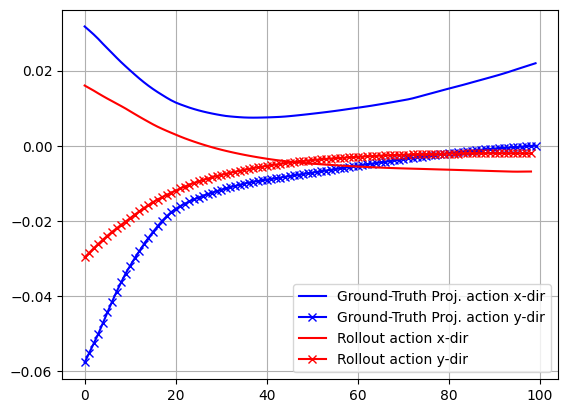

In [12]:
plt.plot(actions_proj_task_1[:,0], label="Ground-Truth Proj. action x-dir", color="blue")
plt.plot(actions_proj_task_1[:,1], label="Ground-Truth Proj. action y-dir", color="blue", marker="x")
plt.plot(traj_actions_test_task[:,0], label="Rollout action x-dir", color="red")
plt.plot(traj_actions_test_task[:,1], label="Rollout action y-dir", color="red", marker="x")
plt.grid()
plt.legend()

In [16]:
def task_inference_loss_fn(task_traj: torch.tensor, proj_traj: torch.tensor):
    """Simple MSE loss comparing a trajectory from the new task and the trajectory projected from the base MDP."""
    return torch.sum(torch.norm(task_traj - proj_traj, dim=1), dim=0)

def task_inference_via_action_matching(w_0: torch.tensor,
                                       policy: callable,
                                       traj_states_new_task: torch.tensor,
                                       traj_actions_new_task: torch.tensor,
                                       generator_lg: torch.tensor,
                                       generator_kg: torch.tensor,
                                       max_gradient_steps: int = 2500) -> Union[torch.tensor, torch.tensor, torch.tensor]:
    
    """Infers the left-action that generated a new task from a trajectory of states and actions from that task.
    Returns the weight of the left-action. The left-action can then be calculated via the matrix exponential.
    Args:
    - w_0: torch.tensor, requires_grad, initialization of the weight
    - policy: policy used to generate the trajectory
    - traj_states_new_task: torch.tensor of shape (traj_length, n_states) trajectory of states in the new task
    - traj_actions_new_task: torch.tensor of shape (traj_length, n_actions) trajectory of actions in the new task
    - generator_lg: torch.tensor of shape (dim_Group, n_states, n_states), infinitesimal generator of the Lie group acting on S
    - generator_kg: torch.tensor of shape (dim_Group, n_actions, n_actions), infinitesimal generator of the Lie group acting on A

    Returns:
    - w*: weight of the left action of the task
    - lg: left-action on the state of the task
    - kg: left-action on the action of the task
    """
    w = torch.tensor(w_0.clone().detach(), dtype=DTYPE, requires_grad=True)
    optimizer = torch.optim.Adam([w], lr=0.0045)
    del w_0

    prev_loss = torch.tensor(torch.inf, dtype=DTYPE)
    pbar = tqdm(range(max_gradient_steps), desc="Computing Task Left-Action Weight...")
    for iter_idx in pbar:

        # Compute group actions given current weight
        lg_task_1_w = left_action_from_weight(generator=generator_lg, weight=w)
        kg_task_1_w = left_action_from_weight(generator=generator_kg, weight=w)

        # Project policy into current task
        actions_proj_task_w, _ = find_left_action_from_task_traj(task_traj_states=traj_states_new_task,
                                                    base_policy=policy,
                                                    Lg=lg_task_1_w,
                                                    Kg=kg_task_1_w)
        actions_proj_task_w_clip = actions_proj_task_w[:-1,:]
        
        # Compute loss
        loss = task_inference_loss_fn(task_traj=traj_actions_new_task, proj_traj=actions_proj_task_w_clip)

        # Update weight
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.4f}")

        if torch.allclose(prev_loss, loss, atol=0.001):
            break
        prev_loss = loss
    return w.detach(), lg_task_1_w.detach(), kg_task_1_w.detach()

In [17]:
traj_states_test_task_th = torch.tensor(traj_states_test_task, dtype=DTYPE)
traj_actions_test_task_th = torch.tensor(traj_actions_test_task, dtype=DTYPE)

w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
w_star, lg_star, kg_star = task_inference_via_action_matching(
    w_0 = w_0,
    policy=model,
    traj_states_new_task=traj_states_test_task_th,
    traj_actions_new_task=traj_actions_test_task_th,
    generator_lg=GENERATOR_LG,
    generator_kg=GENERATOR_KG
)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/3621460786.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/1311138471.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w_0.clone().detach(), dtype=DTYPE, requires_grad=True)
Computing Task Left-Action Weight...:   0%|          | 0/2500 [00:00<?, ?it/s]/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/120197794.py:14: UserWarning: This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in thenew task. Thereb

Roll out policy via equivariance in new task

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/120197794.py:14: UserWarning: This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in thenew task. Thereby, it does not fulfill its theoretical equivariance constraint.
  warnings.warn("This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in the" \


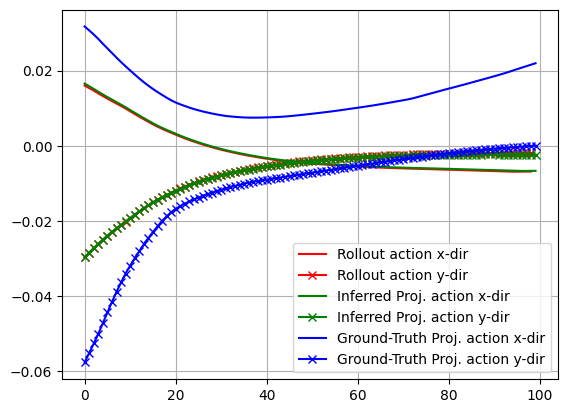

In [18]:
actions_proj_task_star, states_proj_task_star = find_left_action_from_task_traj(task_traj_states=traj_states_test_task,
                                               base_policy=model,
                                               Lg=lg_star,
                                               Kg=kg_star)

plt.plot(traj_actions_test_task[:,0], label="Rollout action x-dir", color="red")
plt.plot(traj_actions_test_task[:,1], label="Rollout action y-dir", color="red", marker="x")
plt.plot(actions_proj_task_star[:,0], label="Inferred Proj. action x-dir", color="green")
plt.plot(actions_proj_task_star[:,1], label="Inferred Proj. action y-dir", color="green", marker="x")
plt.plot(actions_proj_task_1[:,0], label="Ground-Truth Proj. action x-dir", color="blue")
plt.plot(actions_proj_task_1[:,1], label="Ground-Truth Proj. action y-dir", color="blue", marker="x")
plt.grid()
plt.legend()

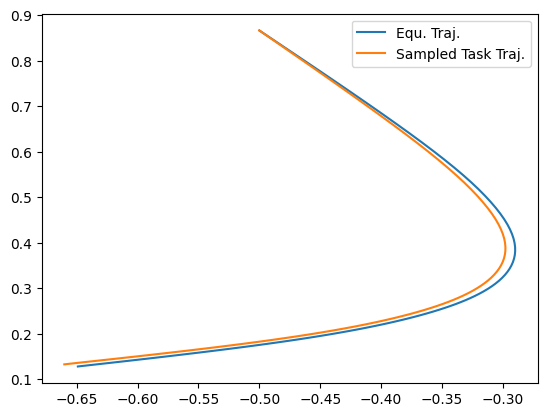

In [19]:
test_env = CircleRotationEnv(s_inits=[start_positions_test[TEST_TASK_IDX]], seed=RANDOM_SEED)

traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=kg_star, Lg=lg_star)
plt.plot(traj_equ[:,0], traj_equ[:,1], label="Equ. Traj.")
plt.plot(traj_states_test_task[:,0], traj_states_test_task[:,1], label="Sampled Task Traj.")
plt.legend()


In [33]:
trajs_test_action_matching = []
actions_all_tasks_test_action_matching = []
lg_stars_action_matching, kg_stars_action_matching = [], []
idx_loop = 0
for states_test, actions_test in zip(trajs_all_tasks_test, actions_all_tasks_test):

    # Convert to torch
    traj_states_th = torch.tensor(states_test, dtype=DTYPE)
    traj_actions_th = torch.tensor(actions_test, dtype=DTYPE)

    w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
    w_star, lg_star, kg_star = task_inference_via_action_matching(
        w_0 = w_0,
        policy=model,
        traj_states_new_task=traj_states_th,
        traj_actions_new_task=traj_actions_th,
        generator_lg=GENERATOR_LG,
        generator_kg=GENERATOR_KG
    )
    lg_stars_action_matching.append(lg_star)
    kg_stars_action_matching.append(kg_star)
    # Create environment of task
    test_env = CircleRotationEnv(s_inits=[start_positions_test[idx_loop]], seed=RANDOM_SEED)

    # Sample trajectory in environment via equivariance
    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=kg_star, Lg=lg_star)

    trajs_test_action_matching.append(traj_equ)
    del test_env
    idx_loop+=1

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/1017066824.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/1311138471.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w_0.clone().detach(), dtype=DTYPE, requires_grad=True)
Computing Task Left-Action Weight...:   0%|          | 0/2500 [00:00<?, ?it/s]/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/120197794.py:14: UserWarning: This approach does not always work as the base policy is optimal in the projection back to the base-MDP but was not optimal in thenew task. There

In [21]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_test_action_matching,
                        legend=True,
                        savepath="trajs_equivar_action_matching")

##  Task Inference via State-Matching

In [69]:
def proj_traj_from_base_to_task(s_0, base_transition_func, base_policy, Lg, traj_length=100):
    """Samples a trajectory in the base environment according to the base policy but projects each state and action to a task tilde induced by Lg.
    s_0: initial state from the base environment
    base_transition_func: transition function of the base environment
    base_policy: Callable, optimal policy in the base environment
    Lg: acts on S, from base to tilde
    """
    trajectory = []

    s_0_tilde = Lg @ s_0
    s_tilde = s_0_tilde

    for _ in range(traj_length):

        trajectory.append(s_tilde.clone())
        a_tilde_np, _ = base_policy.predict(s_tilde.detach().numpy(), deterministic=True)
        a_tilde = torch.tensor(a_tilde_np, requires_grad=False)

        #TODO: We step in the new task, this is probably very error prone as we can't estimate the transition function there.
        s_tilde = base_transition_func(s_tilde, a_tilde)

    return torch.stack(trajectory, dim=0)

In [70]:
TEST_TASK_IDX = 1

task_env = CircleRotationEnv(s_inits=[start_positions_test[TEST_TASK_IDX]], seed=RANDOM_SEED)
traj, _, _ = sample_traj_of_env(task_env, model)
if traj.shape[0] < 100:
    pad_size = (0, 0, 0, 100 - traj.shape[0])  # (pad_left, pad_right, pad_top, pad_bottom)
    traj = torch.nn.functional.pad(torch.tensor(traj), pad_size, mode='constant', value=0)
traj_new_task = torch.tensor(traj, dtype=DTYPE)

In [71]:
import torch
import warnings
from tqdm import tqdm

A_torch = torch.tensor(env.A, dtype=DTYPE)
B_torch = torch.tensor(env.B, dtype=DTYPE)


def base_transition_func_circle_torch(state: torch.tensor, action: torch.tensor, A: torch.tensor, B: torch.tensor):
    """Transition function from the base environment."""
    if torch.allclose(state, torch.tensor([0,0], dtype=DTYPE), atol=0.1):
        return torch.tensor([0,0], dtype=DTYPE)
    state += A @ state + B @ action
    warnings.warn("Using no noise in projected trajectories")
    state += torch.randn(2)* SIGMA_NOISE**0.5 if SIGMA_NOISE > 0 else 0
    return state

def task_inference_loss_fn_batched(task_traj: torch.tensor, proj_traj: torch.tensor):
    """Simple MSE loss comparing a trajectory from the new task and the trajectory projected from the base MDP."""
    return torch.sum(torch.norm(task_traj - proj_traj, dim=2), dim=(0,1))

In [74]:
projected_traj = proj_traj_from_base_to_task(s_0 = torch.tensor([1,0], dtype=DTYPE),
                                             base_transition_func=tran_fn_th,
                                             base_policy=model,
                                             Lg=torch.tensor(lgs_ground_truth[TEST_TASK_IDX+1], dtype=DTYPE)
                                             )

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/4165050435.py:14: UserWarning: Using no noise in projected trajectories
  warnings.warn("Using no noise in projected trajectories")


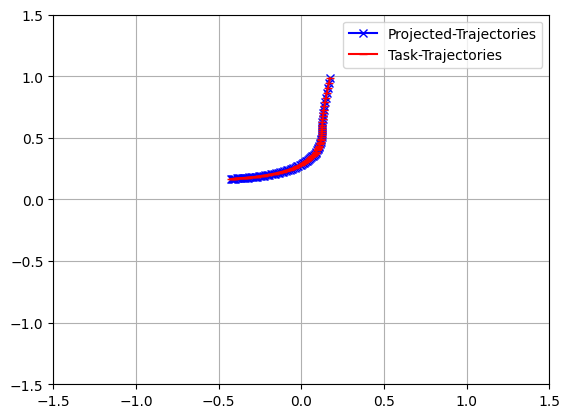

In [78]:
plt.plot(projected_traj[:,0], projected_traj[:,1], label="Projected-Trajectories", marker="x", color="blue")
plt.plot(traj_new_task[:,0], traj_new_task[:,1], label="Task-Trajectories", marker="_", color="red")

projected_traj
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()

In [118]:
def task_inference_via_state_matching(s_0: torch.tensor,
                                      w_0: torch.tensor,
                                      policy: callable,
                                      transition_fn: callable,
                                      traj_task: torch.tensor,
                                      generator_lg: torch.tensor,
                                      max_gradient_steps: int = 2500) -> Union[torch.tensor, torch.tensor]:
    """Infers the left-action of the current task via state matching.
    Args:
    - s_0, initial state in the base-MDP
    - w_0: initialization for the task weight
    - policy: base policy
    - transition_fn: base model transition function
    - traj_task: trajectory sampled from the current task
    generator_lg: infinitesimal generator of the left-action
    """
    
    w = torch.tensor([w_0.clone()], dtype=DTYPE, requires_grad=True)
    task_w_optimizer = torch.optim.Adam([w], lr=0.0045)

    pbar = tqdm(range(max_gradient_steps), desc="Computing Left-Action Weight...")
    for idx_iter in pbar:

        # Compute group actions given current weight
        lg_w = left_action_from_weight(generator=generator_lg, weight=w)

        # Sample a trajectory in the current task (induced by w) in the base policy
        proj_traj = proj_traj_from_base_to_task(s_0 = s_0,
                                base_transition_func = transition_fn,
                                base_policy=policy,
                                Lg=lg_w)
        
        if proj_traj.shape[0] < 100:
            pad_size = (0, 0, 0, 100 - proj_traj.shape[0])  # (pad_left, pad_right, pad_top, pad_bottom)
            proj_traj_pad = torch.nn.functional.pad(torch.tensor(proj_traj), pad_size, mode='constant', value=0)
        else:
            proj_traj_pad = proj_traj
        
        # Compute loss
        loss = task_inference_loss_fn(traj_task, proj_traj_pad)

        # Update weight
        task_w_optimizer.zero_grad()
        loss.backward()
        task_w_optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.4f}")
        if loss < 0.05:
            print("Stopped training early, reached loss threshold.")
            break

    return w.detach(), lg_w.detach()

In [115]:
w_0 = torch.tensor([torch.randn(1)], dtype=DTYPE, requires_grad=True)
s_0 = torch.tensor(start_positions_train[0], dtype=DTYPE)
tran_fn_th = lambda s,a: base_transition_func_circle_torch(state=s, 
                                                           action=a, 
                                                           A=torch.tensor(env.A, dtype=DTYPE), 
                                                           B=torch.tensor(env.B, dtype=DTYPE))

w_star_state_match, lg_star_state_match = task_inference_via_state_matching(s_0=s_0,
                                                        w_0=w_0,
                                                        policy=model,
                                                        transition_fn=tran_fn_th,
                                                        generator_lg=GENERATOR_LG,
                                                        traj_task=traj_new_task)

Computing Left-Action Weight...:   0%|          | 0/2500 [00:00<?, ?it/s]/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/4165050435.py:14: UserWarning: Using no noise in projected trajectories
  warnings.warn("Using no noise in projected trajectories")
Loss: 0.3403:  15%|█▌        | 385/2500 [00:15<01:27, 24.30it/s]         


/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/4165050435.py:14: UserWarning: Using no noise in projected trajectories
  warnings.warn("Using no noise in projected trajectories")


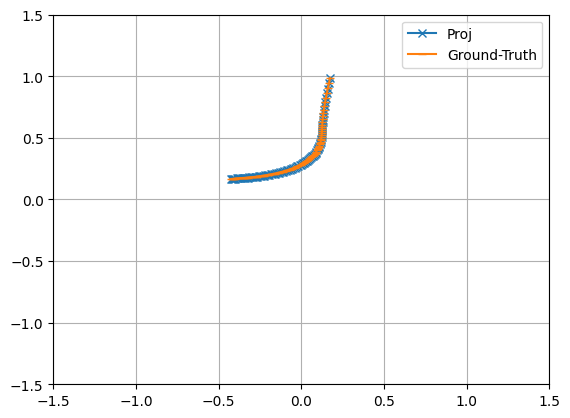

In [88]:
proj_traj = proj_traj_from_base_to_task(s_0 = s_0,
                                base_transition_func = tran_fn_th,
                                base_policy=model,
                                Lg=lg_star_state_match)

plt.plot(proj_traj.detach()[:,0], proj_traj.detach()[:,1], label="Proj", marker="x")
plt.plot(traj_new_task[:,0], traj_new_task[:,1], label="Ground-Truth", marker="_")
plt.grid()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()

### Task inference via state matching

In [119]:
trajs_test_state_matching = []
lg_stars_state_matching = []
kg_stars_state_matching = []

idx_loop = 0
for states_test in trajs_all_tasks_test:

# Convert to torch
    traj_states_th = torch.tensor(states_test, dtype=DTYPE)
    if traj_states_th.shape[0] < 100:
        pad_size = (0, 0, 0, 100 - traj_states_th.shape[0])  # (pad_left, pad_right, pad_top, pad_bottom)
        proj_traj_pad = torch.nn.functional.pad(torch.tensor(traj_states_th), pad_size, mode='constant', value=0)
    else:
        proj_traj_pad = traj_states_th

    w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
    w_star_state_match, lg_star_state_match = task_inference_via_state_matching(s_0=s_0,
                                                        w_0=w_0,
                                                        policy=model,
                                                        transition_fn=tran_fn_th,
                                                        generator_lg=GENERATOR_LG,
                                                        traj_task=proj_traj_pad)
    
    kg_star_state_match = left_action_from_weight(GENERATOR_KG, w_star_state_match)
    lg_stars_state_matching.append(lg_star_state_match)
    kg_stars_state_matching.append(kg_star_state_match)

    # Create environment of task
    test_env = CircleRotationEnv(s_inits=[start_positions_test[idx_loop]], seed=RANDOM_SEED)
    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=kg_star_state_match, Lg=lg_star_state_match)

    trajs_test_state_matching.append(traj_equ)
    del test_env
    idx_loop+=1

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/2768229348.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_0 = torch.tensor(torch.randn(1), dtype=DTYPE)
Computing Left-Action Weight...:   0%|          | 0/2500 [00:00<?, ?it/s]/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/4165050435.py:14: UserWarning: Using no noise in projected trajectories
  warnings.warn("Using no noise in projected trajectories")
Loss: 0.0056:  40%|████      | 1001/2500 [00:42<01:04, 23.40it/s]        
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_19793/2768229348.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_traj_pad = torch.nn.functional.pad(torch.

In [122]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_test_state_matching,
                        legend=False,
                        savepath="trajs_equivar_state_matching")